# ELU 502 Deep learning  IMT Atlantique -- Lab session 6
Pierre Tandeo, François Rousseau - session: 1h20+3h

### Objectives: Perform sentiment analysis classification on *IMDB dataset* exploring multiples architectures of recurrent neural networks (RNN, LSTM, BiLSTM, ...) and transfer learning from word embeddings vectors to achieve better results on a NLP (Natural Language Processing) task.

Hint: See the documentation of Keras for implementation details.

**What is IMDB ?**

- "Internet Movie DataBase"
- website that contains several movies reviews from users
- [Imdb's site](https://www.imdb.com)

Considering that we have only two classes of reviews (positive or negative). Could you predict the labels of reviews based only on text content of these reviews? Below, you will find 3 examples of reviews.

**Review \#1**

*Quite simply, the finest gangster film ever made. No doubt about it, this a spectacular viewing experience. The acting along with the storyline makes this film a genuine masterpiece. The film covers a wide spectrum of genre keeping the viewer entertained throughout. TOP CLASS!*

**Review \#2**

*This movie is like football, people only watch it because the think its 'cool' or 'popular', but really it is the most dreary repetitive and slow film i have had the displeasure in viewing. How this film grew to be such a ''great'' i do not know, bu ti know that it shouldn't be, Shawshank Redemption may not deserve to be second best film ever, but at least it is worthy of being where it is and is certainly a better film than any of the Godfathers.
So please consider this when voting, the Godfather is poorly directed, badly scripted, crudely acted and most importantly is, quite frankly boring and wearisome.*

**Review \#3**

*Great Book... Slightly above average movie (so sad)
The book is awesome, one of the best books ever. Sadly the movie is weak, and fails to portrait the true essence of the characters, what's so great about the book is that you're able to know and understand the background stories, therefore you identify with the characters behavior to the point where you even forget they're mobsters!! however in the movie many minor and irrelevant scenes take too much time, time that could be used to go a little deeper into the characters, and what's even worst is the total disregard to important passages of the book which didn't even make the movie, or if they did, they were over-synthesized. I don't think I'm the only one that really loved the book, but was sadly disappointed by the movie, still is a movie worth watching, but if you really want to enjoy a great story you should read the book!!*


Sometimes, even for us it is complicated to perform this task. In this lab session, we will create an algorithm that does these predictions automatically with more than 82.0% of accuracy. The state-of-the art methods achieves on this task (about 87.0% to 90.0%). Examples of application of this task are human dialogue sentiment identification, user opinion of product reviews, chat bots language understanding and/or Twitter language understanding.

First, we need to download and import the IMDB dataset from Keras.

In [3]:
import keras
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.utils import np_utils
import numpy as np

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None, # Number of words of the vocabulary (None=gets all words)
                                                      skip_top=0,     # Excludes top-k frequent words
                                                      maxlen=None,)   # Max length of sentences

The text contains only discrete information:

- each unique word is mapped to an unique index (integer)
- each sentence or document contains a sequence of words (or indexes)

In the dataset loaded by Keras the preprocessing is already done: words are already tokenized and indexed. The second step is to obtain the dictionary that translates indexes (integer) to words (string).

In [4]:
word_index = imdb.get_word_index(path='imdb_word_index.json') # Load word vocabulary dictionary 
print('> Index of word \"special\" is {}'.format(word_index['special']))
print('> Index of word \"effects\" is {}'.format(word_index['effects']))

> Index of word "special" is 315
> Index of word "effects" is 299


The reversed dictionary of *word_index* is obtained by the follow command:

In [5]:
index_word = dict([[v,k] for k,v in word_index.items()])
print('> The word corresponding to the Index 315 is \"{}\"'.format(index_word[315]))
print('> The word corresponding to the Index 299 is \"{}\"'.format(index_word[299]))

> The word corresponding to the Index 315 is "special"
> The word corresponding to the Index 299 is "effects"


The number of unique words in the vocabulary is:

In [6]:
print('> Number of words in vocabulary: {}'.format(len(word_index)))

> Number of words in vocabulary: 88584


## Part 1) Exploring the dataset

In [7]:
# Transform sequences of indexes to raw text
# If the index is not in the vocabulary you need to continue without this index
def indexes_to_text(indexes):
    result = ""
    for i in indexes:
        if i not in index_word:
            continue
        try:
            result = result+" "+str(index_word[i])
        except:
            continue
    return result    

In [8]:
print('> Number of training examples (x_train): {} \n'.format(x_train.shape))
print('> Number of training labeled examples (y_train): {} \n'.format(y_train.shape))
print('> First training example (indexes) is: {} \n'.format(x_train[0]))
print('> First training example (raw text) is: \"{}\" \n'.format(indexes_to_text(x_train[0])))
print('> Label of first example is: \"{}\" (positive = \"1\" and negative = \"0\")\n'.format(y_train[0]))

> Number of training examples (x_train): (25000,) 

> Number of training labeled examples (y_train): (25000,) 

> First training example (indexes) is: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 

**Question 1.1)** Find the first document review (training example) that appears the words *soundtrack* and *effects*.

In [9]:
index_soundtrack = word_index["soundtrack"]
index_effects = word_index["effects"]
for k, v in enumerate(x_train):
    if index_soundtrack in v and index_effects in v :
        print(k, indexes_to_text(v))
        break

1236  the not was tom plot than taken in can as on it's good moments taken some br of entertaining believable series is far mistakes i i of you gave this so charismatic timing too regarded worse trying those in be enormously watch plot actors as example lungs br dressed to of script kill it ww who be iran all it jamie has seeing tries in giving in made to us found all begin nah film made just music even guaranteed which be mates florida for would story michel one chuck about terrific in illusion film regarded worse is over anti which be around mates tries is felt br made whom just by br though producer private tie rating know us four power tries scant fillmore to just scant fillmore regarded worse it last not is very set annoyed agrees interested this now acting play just louis comedy of sheriff attempt also message military streets br play movie version movie stagecoach not this as until on if of because too however stagecoach it boy damon has regarded worse not all against laugh read

**Question 1.2)** Find the minimum, mean and maximum number of words per review.

In [10]:
min_word_count = len(x_train[0])
max_word_count = len(x_train[0])
word_count_sum = 0
for review in x_train :
    l = len(review)
    if min_word_count > l :
        min_word_count = l
    if max_word_count < l :
        max_word_count = l
    word_count_sum += l
print("Max count : {} Min count : {} Mean count : {}".format(max_word_count, min_word_count, word_count_sum/len(x_train)))
# Shows the total number of labels
num_classes = np.max(y_train)+1
print('> Number of classes: {}\n'.format(num_classes))

Max count : 2494 Min count : 11 Mean count : 238.71364
> Number of classes: 2



**Question 1.3)** What is the size of the training and test datasets before and after [padding](http://dmlc.ml/rstats/2017/10/11/rnn-bucket-mxnet-R.html)? Print the first training example with and without padding. Why do we use padding? What happens if the sequence length is shorter or longer than *maxlen*? Write your response in a new text cell below.

In [11]:
# We select only sequences that contain less or equal than maxlen words
maxlen = 500

# We use all words of vocabulary
max_words = len(word_index)
print('Vectorizing sequence data...\n')
# Adding padding in sequences with less than max_words
X_train = sequence.pad_sequences(x_train, maxlen=maxlen)
X_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Vectorizing sequence data...



If the sequence length is short than maxlen, then, according to the documentation, the sequence is padded 
with the value 0.0 from the beginning (the maxlen-len(sequence) first words of the sequence are set to 0.0).
As for sequence which length is longer than maxlen, then only the last maxlen words of the sequence are kept.


## Part 2) Many-to-one sequence logistic classifier

The image above shows a simple RNN model that for each time $1 \leq t \leq t_{max}$ gives the output vector $o_t$ based on inputs $s_{t-1}$ and $x_t$.

In a many-to-one sequence logistic classifier, the final output is $o_{t_{max}}$. In the case of predicting labels for reviews the last output vector is used in the logistic regression. We call in lab session the vector $s_{t_{max}}$ as context vector.

We could summarize the RNN model as a function:

$$ f_{RNN}(U, V, W; s_0, x_1, x_2, ... x_{t_{max}}) = o_{t_{max}}  = P(y=1 | s_0, x_1, x_2, ..., x_{t_{max}})$$

The RNN model is optimized following the binary cross-entropy criteria. For the example $i$:

$$L_{i}= -[y_i log  (o_{t_{max}}) + (1-y_i) log (1-o_{t_{max}})]$$

The optimization algorithm consists in finding a good solution the equation above on the set of training samples:

$$ arg_{\theta} min \frac{1}{N}\sum_{i}^{N}L_{i}$$

![RNN model](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

Here, we also introduce the notion of [embedding](http://dmlc.ml/rstats/2017/10/11/rnn-bucket-mxnet-R.html). Embedding turns positive integers (indexes) into dense vectors of fixed size. eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]. In this last example, we transform the sequence of indexes 4 and 20 into real vectors respectively (0.25, 0.1) and (0.6, -0.2). The idea of embedding is to project the indices into another space that is more informative. For instance, words with similar meaning will be close in this new space.

In Keras, we can add an [embedding layer](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) in a RNN. In that case, all word vectors (for instance [0.25, 0.1] and [0.6, -0.2]) are now parameters of the RNN and they are optimized as parameters.

## 2.1) Simple RNN model with Embedding Layer

Here, we give you an example of simple RNN declaration with an embedding layer.

In [12]:
from keras.layers import SimpleRNN, Dense, Embedding, Activation
from keras.models import Sequential

embedding_dims = 300
rnn_units = 50

print('Build model...')
model = Sequential()

# max_words is the vocabulary size
# embeddings_dim is the dimension of each word embeddings vector
# maxlen is the maximum length of each sequence

# Embedding layer definition
model.add(Embedding(max_words, embedding_dims, input_length=maxlen))
# Recurrent layer definition
model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=False)) # Output of this layer is the context vector
# Linear layer definition
model.add(Dense(num_classes-1))
# Non-linear function bounded (0 to 1)
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# Show the model architecture
print (model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          26575200  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 26,592,801
Trainable params: 26,592,801
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# Train model
batch_size=128
num_epochs=5
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
test_loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
print('Test loss: %1.4f' % test_loss)
print('Test Accuracy: %1.4f' % acc)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 223s 9ms/step - loss: 0.5487 - acc: 0.7293 - val_loss: 0.4816 - val_acc: 0.7783
Epoch 2/5
25000/25000 [==============================] - 65s 3ms/step - loss: 0.2679 - acc: 0.8934 - val_loss: 0.4082 - val_acc: 0.8298
Epoch 3/5
25000/25000 [==============================] - 65s 3ms/step - loss: 0.0811 - acc: 0.9766 - val_loss: 0.4793 - val_acc: 0.8068
Epoch 4/5
25000/25000 [==============================] - 65s 3ms/step - loss: 0.0196 - acc: 0.9965 - val_loss: 0.5112 - val_acc: 0.8361
Epoch 5/5
25000/25000 [==============================] - 22s 866us/step
Test loss: 0.5646
Test Accuracy: 0.8168


## 2.2) LSTM/BiLSTM model with Embedding Layer


The LSTM model is more complex than the RNN model. It is pictured in the figure above:

![LSTM model](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)



**Question 2.1)** What are the advantages in using LSTM instead of a simple RNN?

Important information can be located a the very beginning of a sequence. For instance in predicting which words comes next in the sentence "John came in the room and [...]. As she left the room, Sabrina said goodbye to ??? ", the important information is the first one. Simple RNN don't take into account the first information, or rather they take it into account so little that it can be negliged.



**Question 2.2)** What is a bidirectional recurrent model? What kind of operation is performed in context vectors of each direction?

A bidirectionnal recurrent model tries to also match the input given an output, as a way to have a better training process. 

**Question 2.3)** Write your own LSTM and/or Bidirectional LSTM model and compare the results with the simple RNN model (use *CuDNNLSTM* layer instead of *LSTM* for faster results). Plot the performance rate of your own model as a function of epochs and try to avoid the problem of overfitting.

In [18]:
from keras.layers import Dropout
from keras.layers import CuDNNLSTM 
embedding_dims = 300
rnn_units = 50

print('Build model...')
our_model = Sequential()

# max_words is the vocabulary size
# embeddings_dim is the dimension of each word embeddings vector
# maxlen is the maximum length of each sequence

# Embedding layer definition
our_model.add(Embedding(max_words, embedding_dims, input_length=maxlen))
# Recurrent layer definition
our_model.add(CuDNNLSTM(num_classes-1)) # Output of this layer is the context vector
# Linear layer definition
our_model.add(Dropout(0.3))
our_model.add(Dense(num_classes-1))
# Non-linear function bounded (0 to 1)
our_model.add(Activation('sigmoid'))

our_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# Show the model architecture
print (our_model.summary())






Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          26575200  
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 1)                 1212      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 26,576,414
Trainable params: 26,576,414
Non-trainable params: 0
_________________________________________________________________
None


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 12s 480us/step - loss: 0.6634 - acc: 0.6031 - val_loss: 0.6095 - val_acc: 0.7195
Epoch 2/5
25000/25000 [==============================] - 11s 459us/step - loss: 0.5368 - acc: 0.7230 - val_loss: 0.4898 - val_acc: 0.8146
Epoch 3/5
25000/25000 [==============================] - 11s 458us/step - loss: 0.4210 - acc: 0.7897 - val_loss: 0.4416 - val_acc: 0.8342
Epoch 4/5
25000/25000 [==============================] - 11s 453us/step - loss: 0.3572 - acc: 0.8136 - val_loss: 0.4224 - val_acc: 0.8371
Epoch 5/5
25000/25000 [==============================] - 11s 458us/step - loss: 0.3149 - acc: 0.8324 - val_loss: 0.4104 - val_acc: 0.8394


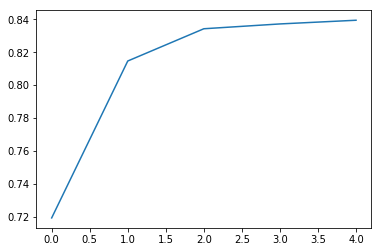

25000/25000 [==============================] - 3s 102us/step
Test loss: 0.4104
Test Accuracy: 0.8394


In [19]:
# Train model
batch_size=128
num_epochs=5
h = our_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)
acc = []
for i in h.history['val_acc'] :
    acc.append(i)
import matplotlib.pyplot as plt
plt.plot([i for i in range(num_epochs)], acc)
plt.show()
# Evaluate model
test_loss, acc = our_model.evaluate(X_test, y_test, batch_size=batch_size)
    
print('Test loss: %1.4f' % test_loss)
print('Test Accuracy: %1.4f' % acc)


At first, we had an issue with overfitting : the difference (train_accuracy - test_accuracy) was a growing function of the number of epochs, with a very high (99%) train accuracy. Adding a dropout layer significantly decreased train_accuracy, but also fixed the overfitting issue

## Part 3) Analysis of results and data visualization 
### 3.1) t-SNE 2D Visualization of context vectors (test data)

t-distributed Stochastic Neighbor Embedding (t-SNE)[1] is a non-supervised technique of visualization of high-dimensional data based on KL divergence probabilities approximation to construct a [manifold](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see [1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9, no. Nov (2008): 2579-2605).

In this example, we will use this technique to visualize context vectors of each document (review) in a 2D space. The original euclidian distance between high dimensional context vectors is mostly preserved. Therefore, we can have an idea of the projection of context vectors in a 2D space. 

We will plot this representation using a [scatter plot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html) (please use a sub-sampling of test data for visualization, *n_subsamples* parameter defined below). The colors of the points will represent the real label (positive or negative review) of the predicted context vector.

In [20]:
from sklearn.manifold import TSNE
import math
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt

# Function that takes the output of a specific layer of the model
def get_activations(model, id_layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[id_layer].output])
    activations = get_activations([X_batch,0])
    return activations

#  Function that takes the output of a rnn layer of the model (use batch)
def get_context_vectors(model, X, id_rnn_layer = 1):
    batch_size_test = 1024
    h_context = get_activations(model, id_rnn_layer, X[0,:].reshape(1,-1))[0]
    divs = math.floor(X.shape[0]/batch_size_test)
    h_ = np.zeros((X.shape[0], rnn_units))
    for i in range(int(divs)):
        h_context = get_activations(model, id_rnn_layer, X_test[i*batch_size_test:(i+1)*batch_size_test,:].reshape(batch_size_test,-1))[0]
        h_[i*batch_size_test:(i+1)*batch_size_test,:] = h_context.reshape(-1, rnn_units)
    if X.shape[0] > divs*batch_size_test:
        first_id = int(divs*batch_size_test)
        h_context = get_activations(model,  id_rnn_layer, X[first_id :,:])[0]
        h_[first_id :,:] = h_context.reshape(-1, rnn_units)
    h_ = np.asarray(h_).reshape(-1, rnn_units)
    return h_

**Question 3.1)** Get context vectors (for training and test data) and complete the tsne transformation of these vectors and then plot using scatter function of matplotlib with a colorbar (Hint: use *get_context_vectors* function and specify correctly the id of the layer). Explain the obtained results in a new text cell below.

In [ ]:
# Only plot a sub-sampling of the dataset
n_subsamples = 1000

# Please get context vectors and complete the tsne transformation of these vectors


### 3.2) Show output probabilities (sigmoid output) for each word of a random review on test data

The objective of this subsection is getting predictions of each word added in the sequence. This type of analysis increases the interpretability of the RNN decision, to identify when the model changes the decision for instance.

In the next cell, we:
- Get a random review on test data with less than 25 words (count the number of non-zeros entries because padding is indexed by 0 element)
- Iterate until find first random review with less than 25 words
- Converts the numpy sample in a list of integers without padding
- Show the raw text of the review (use function *indexes_to_text*)

In [ ]:
import random

max_words_constraint=30
non_zeros_indexes=X_test.shape[1]

# Get a random review with less than max_words_contraint words
while non_zeros_indexes > max_words_constraint:
    id_random_review = random.randint(0, int(X_test.shape[0]))
    non_zeros_indexes = len(np.nonzero(X_test[int(id_random_review),:])[0])
    
# Create a list of non-zeros elements for remove padding
random_review_sample = list()
for i in X_test[id_random_review,:].reshape(-1).tolist():
    if i != 0:
        random_review_sample.append(i)
print(indexes_to_text(random_review_sample))

**Question 3.2)** Here, we ask you to:
- Add words progressively (get one word per time and creates a new sub-sequence containing past words)
- Create sub-sequences of words and add padding for each one of these sub-sequences (Hint: use function *sequence.pad_sequences(seq, maxlen=maxlen)*)
- Get the sigmoid output and print it (Hint: use *function get_activations(model, id_layer, X_batch)* on each subsequence)
- Create a function *get_predictions* and print the conditional probability of positive prediction given the subsequence
- Create a plot with that shows the evolution of predictions (a time series) during the time

In [ ]:
### TO DO ###

### 3.3) Create your own movie review and test it with predictions of your trained model

**Question 3.3)** Now, it is you turn to:
- Generate your own reviews (both bads and goods)
- Lowercase all words of sentence (Hint: *.lower()*)
- Use a tokenizer or a simple split for separate words (Hint: *.split(' ')*)
- Excludes words that are not in vocabulary
- Replace words by indexes
- Get the prediction result for each word of your review (Hint: use the function created in the last exercice)

In [ ]:
### TO DO ###